# Empirical Mode Decomposition (EMD) tutorial
### [Scott Cole](sxcole.com)
### 17 January 2016

This notebook illustrates how empirical mode decomposition (EMD) decomposes a signal into multiple rhythmic components.

**Outline**

1. EMD function code
2. Example decomposition
3. Decomposition algorithm

A future notebook will demonstrate how well EMD works at decomposing oscillations in a few different neural data sets.
A future notebook will propose a method for choosing the criterion for an IMF (a key free parameter in the algorithm).

**Some background**
* This method is termed **empirical** mode decomposition because it contrasts to theoretical decomposition, like that based on the Fourier Transform. So it has some advantages when dealing with complicated real-life signals, which are often nonstationary (i.e. not oscillating at the same frequency throughout time). For nonstationary signals, applying a bandpass filter over a certain frequency range may not be ideal, as it will likely attenuate some aspects of the signal you want to preserve.
* EMD stays true to our data by sticking in the time domain and not mapping to something like the frequency domain where we sometimes implicitly make questionable assumptions for our analysis.
* [Intrinsic mode functions](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform#Intrinsic_Mode_Functions_.28IMF.29) (IMFs) are the fancy names given to the signal components identified by EMD because the satisfy the following criteria:
    1. In the whole data set, the number of extrema and the number of zero-crossings must either be equal or differ at most by one.
    2. At any point, the mean value of the envelope defined by the local maxima and the envelope defined by the local minima is zero.
* Resultant IMFs therefore are generally monotonic between their peaks (above 0) and troughs (below 0). Therefore, the Hilbert transform which is commonly used to extract the instantaneous phase and amplitude of a signal will yield clean results. This strategy of applying EMD and Hilbert transform to get instantaneous frequency of a nonstationary function is called the [Hilbert-Huang Transform](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform). 
* There are a [variety of applications](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform#Current_Applications) outside of neuroscience including finance, geophysics, and many other fields of physics. However, I question applications that subsequently apply Fourier analysis onto these components... [they could have gotten just as good of seizure discrimination using regular Fourier analysis instead of EMD](http://www.hindawi.com/journals/jece/2008/293056/).

**Advantages of EMD**
* Characteristics of a signal's nonstationary frequency are preserved, in contrast to typical narrow bandpass filtering
* The instantaneous phase and frequency calculations of an IMF with the Hilbert transform yield clean results

**Disadvantages of EMD**
* Need to choose a free parameter (criterion for an IMF) which will result in very different
* Oscillations of interest may be spread out among multiple IMFs

# 1. EMD function code

**Load libraries**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
sns.set_style('white')

import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

**EMD functions**

In [2]:
def emd(x, nIMF = 3, stoplim = .001):
    """Perform empirical mode decomposition to extract 'niMF' components out of the signal 'x'."""
    
    r = x
    t = np.arange(len(r))
    imfs = np.zeros(nIMF,dtype=object)
    for i in range(nIMF):
        r_t = r
        is_imf = False
        
        while is_imf == False:
            # Identify peaks and troughs
            pks = sp.signal.argrelmax(r_t)[0]
            trs = sp.signal.argrelmin(r_t)[0]
            
            # Interpolate extrema
            pks_r = r_t[pks]
            fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
            pks_t = fip(t)
            
            trs_r = r_t[trs]
            fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
            trs_t = fitr(t)
            
            # Calculate mean
            mean_t = (pks_t + trs_t) / 2
            mean_t = _emd_complim(mean_t, pks, trs)
            
            # Assess if this is an IMF (only look in time between peaks and troughs)
            sdk = _emd_comperror(r_t, mean_t, pks, trs)
            
            # if not imf, update r_t and is_imf
            if sdk < stoplim:
                is_imf = True
            else:
                r_t = r_t - mean_t
                
        
        imfs[i] = r_t
        r = r - imfs[i] 
        
    return imfs


def _emd_comperror(h, mean, pks, trs):
    """Calculate the normalized error of the current component"""
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    return np.sum(np.abs(mean[samp_start:samp_end]**2)) / np.sum(np.abs(h[samp_start:samp_end]**2))


def _emd_complim(mean_t, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

# 2. Example decomposition
* Notice that the prominent frequency range decreases for subsequent IMFs.
* IMF #3 captures the majority of the dominant ~20Hz oscillation in the signal.
    * However, the shape characteristics of these oscillations are not well preserved in just considering the 1 component.

**Import data**

In [3]:
minN = 7000
maxN = 9000
x = np.load('./exampledata.npy')
x = x[minN:maxN+1]
t = np.arange(0,len(x)*.001,.001) 

**Calculate and plot components**

In [4]:
imfs = emd(x, nIMF = 5)

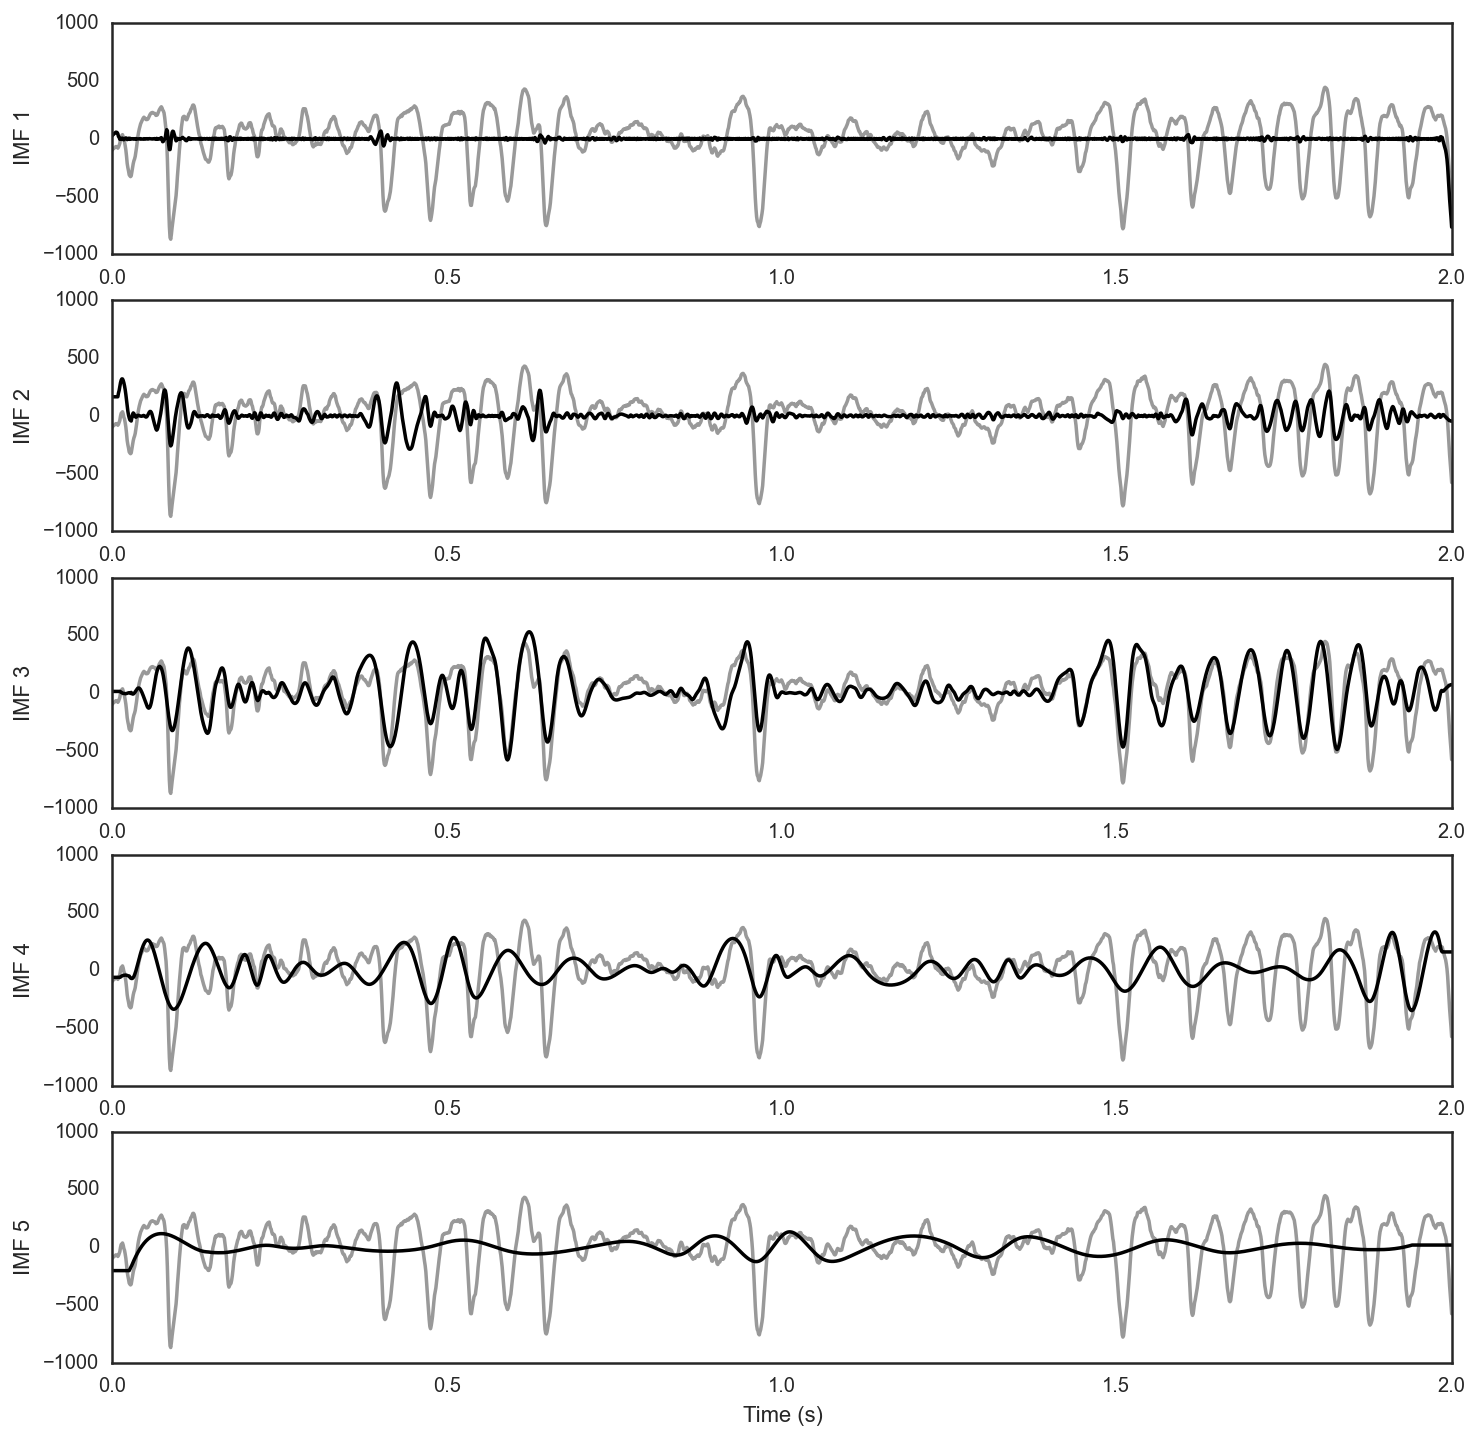

In [5]:
plt.figure(figsize=(12,12))
for i in range(len(imfs)):
    plt.subplot(len(imfs),1,i+1)
    plt.plot(t,x,color='0.6')
    plt.plot(t,imfs[i],'k')
    plt.ylim([-1000,1000])
    plt.ylabel('IMF '+np.str(i+1))
    if i == len(imfs)-1:
        plt.xlabel('Time (s)')

# 3. EMD algorithm

EMD is an interative algorithm. Begin with a signal and repetitively modify it until it satisfies a certain criterion. Modify the original signal, and repeat the procedure to obtain each component.

The next section outlines the different stages of the algorithm:

1. the steps that are iteratively applied to a signal to get a component.
2. the criterion for a processed signal to be an IMF
3. continuation to get all IMFs

**Define decomposition parameters**

In [6]:
nIMF = 3 # Number of components in which to decompose the signal
stoplim = .001 # Criterion to stop iteration and declare a signal to be a component

### Iteration Step 1. Find all relative extrema

In [7]:
x_temp = x
pks = signal.argrelmax(x_temp)[0]
trs = signal.argrelmin(x_temp)[0]

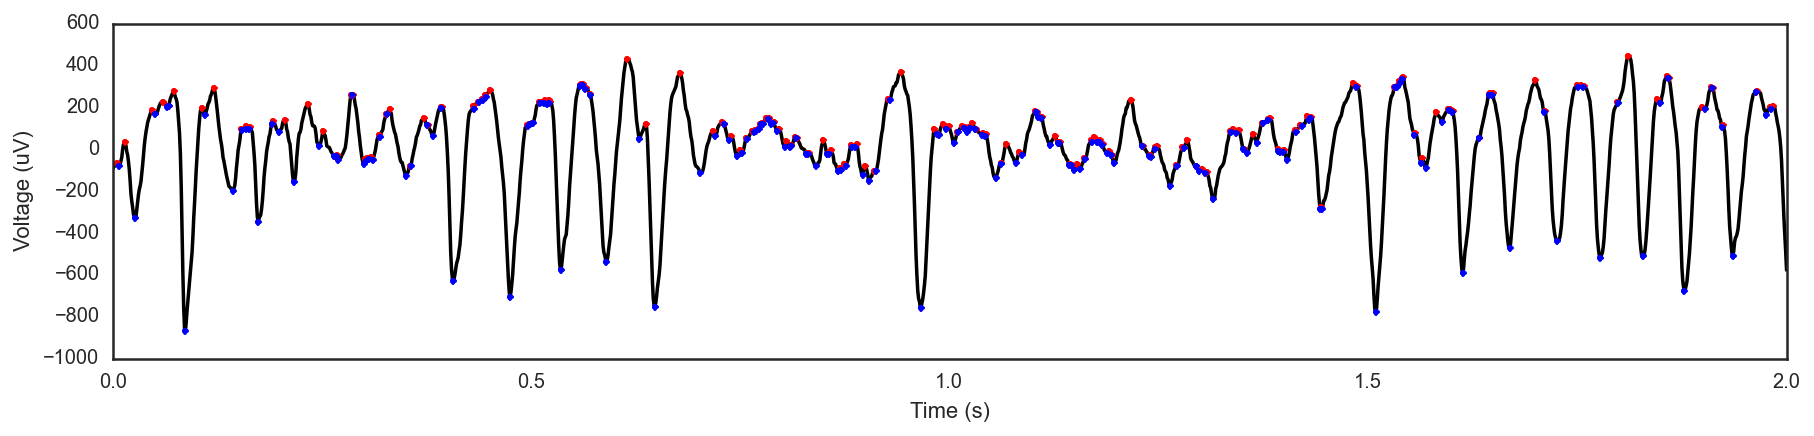

In [8]:
# Plot
plt.figure(figsize=(15,3))
plt.plot(t,x_temp,'k')
plt.plot(t[pks],x_temp[pks],'r.')
plt.plot(t[trs],x_temp[trs],'b.')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')

### Iteration Step 2. Interpolate extrema

In [9]:
x_pks = x[pks]
fip = sp.interpolate.InterpolatedUnivariateSpline(pks,x_pks,k=3)
pks_t = fip(range(len(x)))

x_trs = x_temp[trs]
fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,x_trs,k=3)
trs_t = fitr(range(len(x)))

(-1000, 1000)

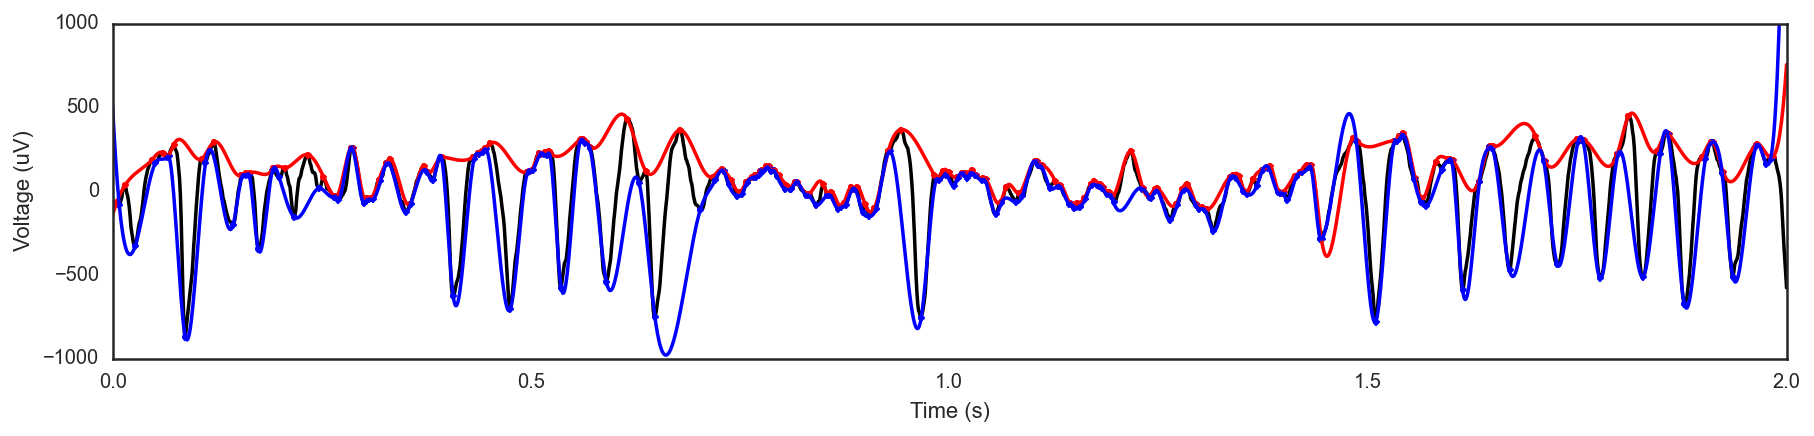

In [10]:
# Plot
plt.figure(figsize=(15,3))
plt.plot(t,x,'k')
plt.plot(t[pks],x_temp[pks],'r.')
plt.plot(t[trs],x_temp[trs],'b.')
plt.plot(t,pks_t,'r')
plt.plot(t,trs_t,'b')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.ylim([-1000,1000])

### Iteration Step 3. Calculate mean of extrema envelopes

In [11]:
mean_t = (pks_t + trs_t) / 2

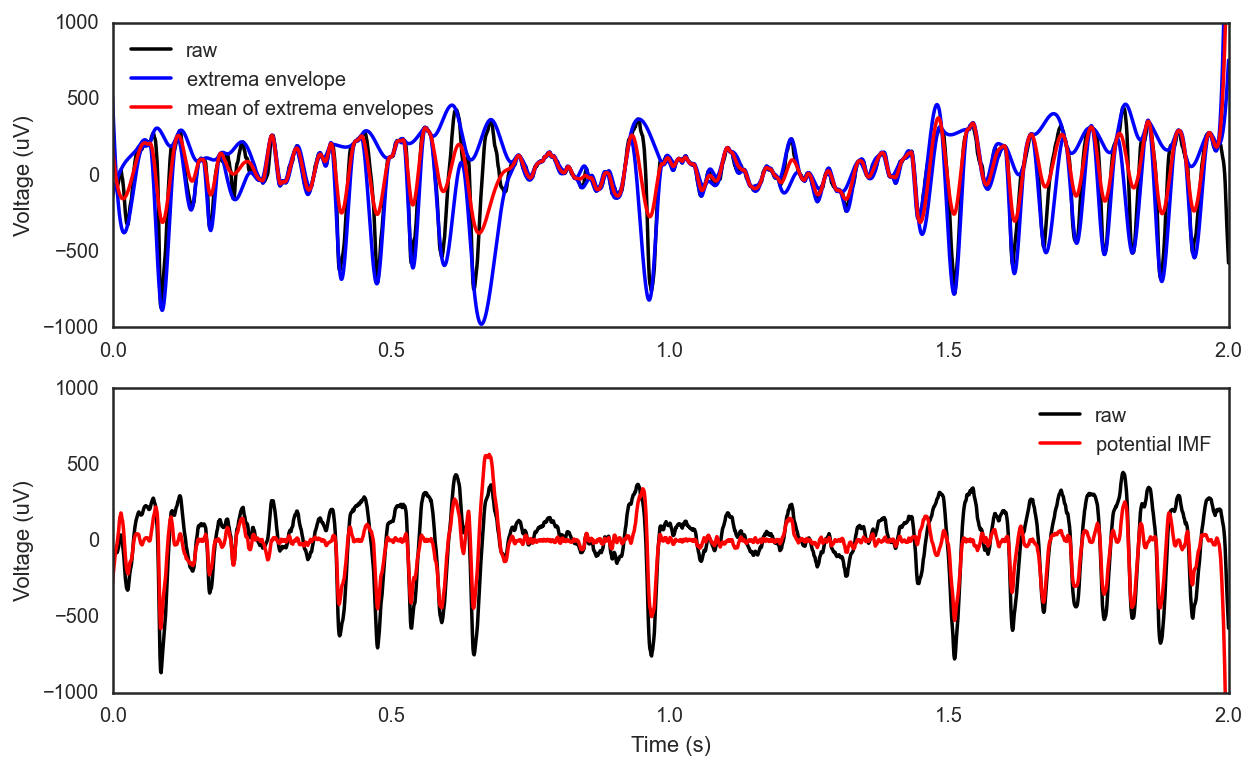

In [12]:
# Plot
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t,x,'k',label='raw')
plt.plot(t,pks_t,'b',label='extrema envelope')
plt.plot(t,trs_t,'b')
plt.plot(t,mean_t,'r',label='mean of extrema envelopes')
plt.ylabel('Voltage (uV)')
plt.ylim([-1000,1000])
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(t,x,'k',label='raw')
plt.plot(t,x-mean_t,'r',label='potential IMF')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.ylim([-1000,1000])
plt.legend(loc='best')

Notice the high frequency components of the signal are most preserved

### Iteration Step 4. Determine if signal satisfies the requirement to be an IMF

The result of iteration step 4 is declared as an IMF if the mean of its extrema envelope is sufficiently close to 0

In [13]:
samp_start = np.max((np.min(pks),np.min(trs)))
samp_end = np.min((np.max(pks),np.max(trs))) + 1
sdk = np.sum(np.abs(mean_t[samp_start:samp_end]**2)) / np.sum(np.abs(x_temp[samp_start:samp_end]**2))

if sdk < stoplim:
    is_imf = True
else:
    x_temp = x_temp - mean_t
    is_imf = False

If the signal satisfies the criterion:

1. It is defined as a component
2. The component is subtracted from the original signal
3. The iterative steps 1-4 are repeated starting with the signal from (2)

If the signal does not satisfy the criterion:

1. The mean of the extrema envelopes is subtracted from the original signal.
2. The iterative steps 1-4 are repeated starting with the signal from (1)

# Visualization of iterations
In the plots below, the result of each iteration is plotted until the criterion for an IMF is achieved. Gray shows the original signal.

In [14]:
nIMF = 3
imfs = np.zeros(nIMF,dtype=object)

In [17]:
def findnextcomponent(x,orig,t):
    """Find the next IMF of the input signal 'x' and return it as 'r'.
    The plots are compared to the original signal, 'orig'."""
    r_t = x
    is_imf = False

    while is_imf == False:
        # Identify peaks and troughs
        pks = sp.signal.argrelmax(r_t)[0]
        trs = sp.signal.argrelmin(r_t)[0]

        # Interpolate extrema
        pks_r = r_t[pks]
        fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
        pks_t = fip(range(len(r_t)))

        trs_r = r_t[trs]
        fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
        trs_t = fitr(range(len(r_t)))

        # Calculate mean
        mean_t = (pks_t + trs_t) / 2
        mean_t = _emd_complim(mean_t, pks, trs)

        # Assess if this is an IMF
        sdk = _emd_comperror(r_t, mean_t,pks,trs)

        # debug: make sure everything looks right, because getting weird interp error after a few iterations; error not converging?
        plt.figure(figsize=(10,1))
        plt.plot(orig,color='0.8')
        plt.plot(r_t - mean_t,'k')
        plt.ylim((-1000,1000))

        # if not imf, update r_t and is_imf
        if sdk < stoplim:
            is_imf = True
            print 'IMF found!'
        else:
            r_t = r_t - mean_t

    return x - r_t

**IMF 1**

IMF found!


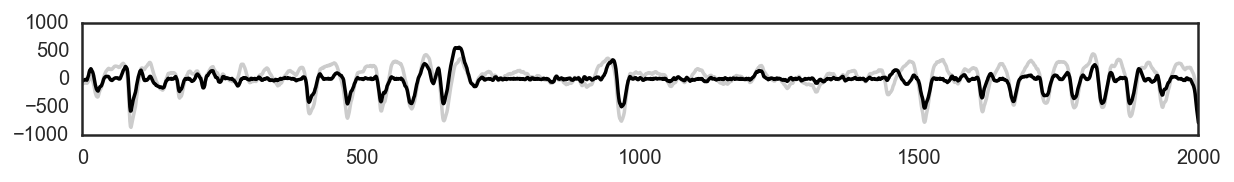

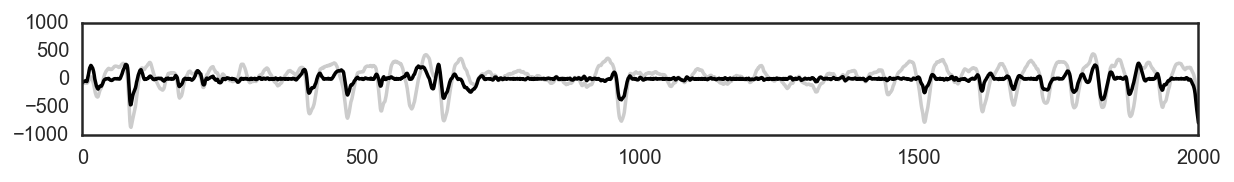

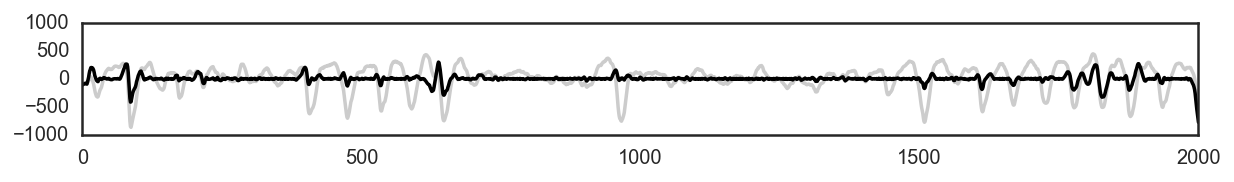

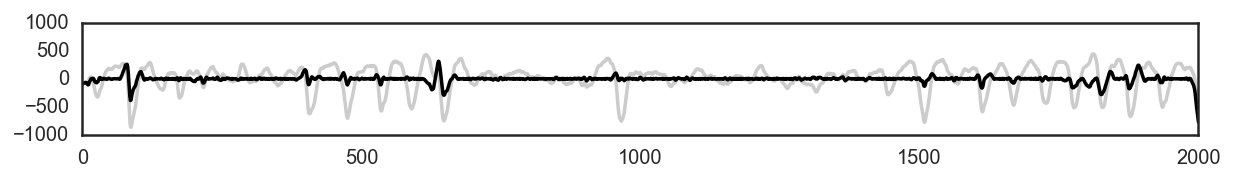

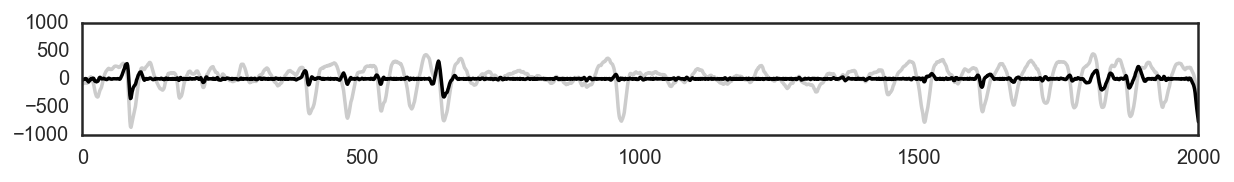

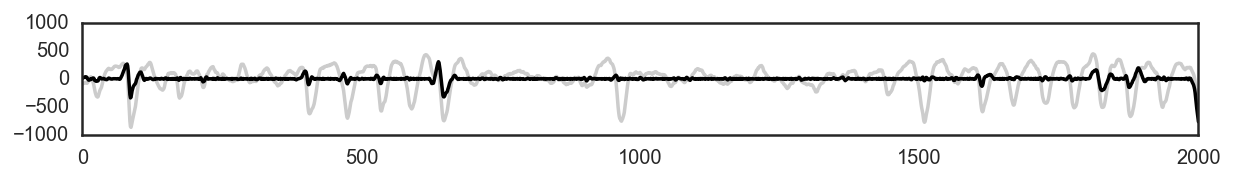

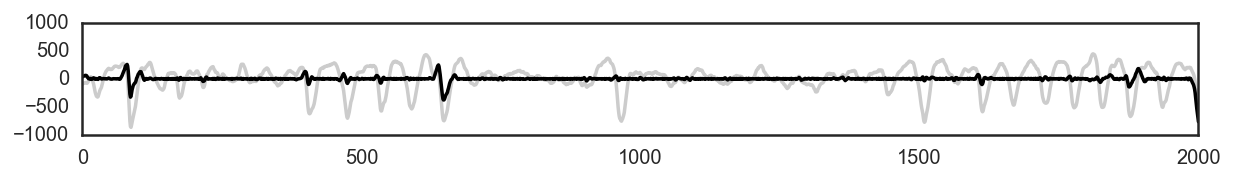

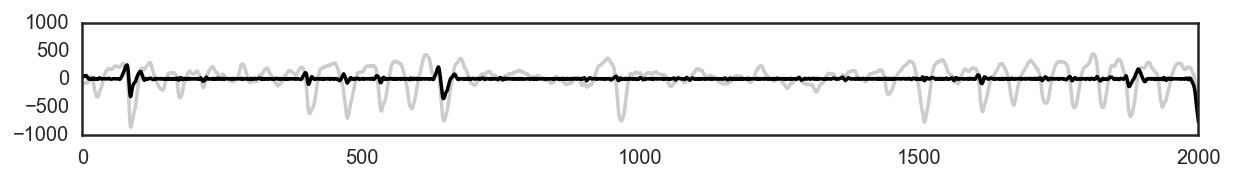

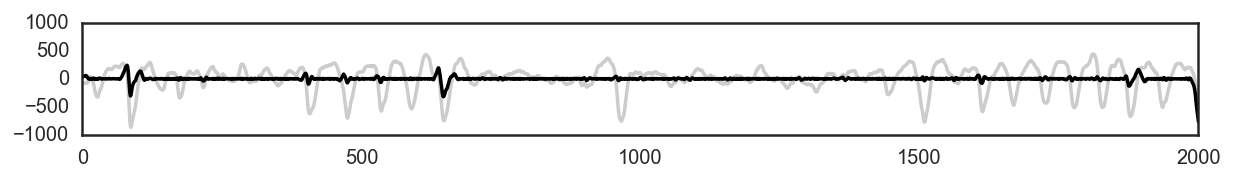

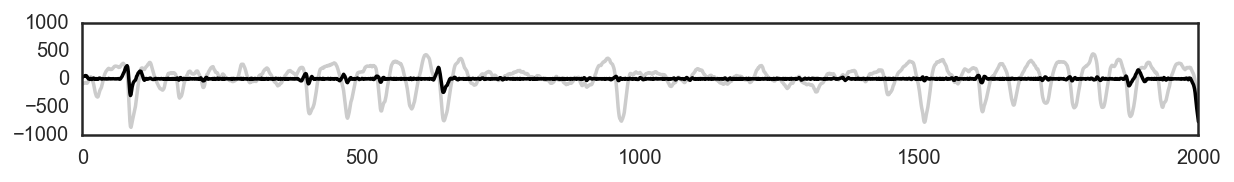

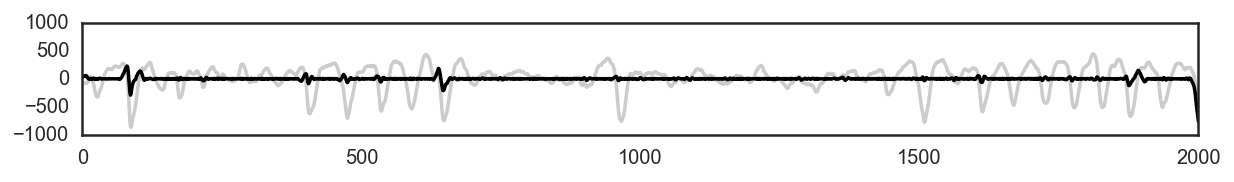

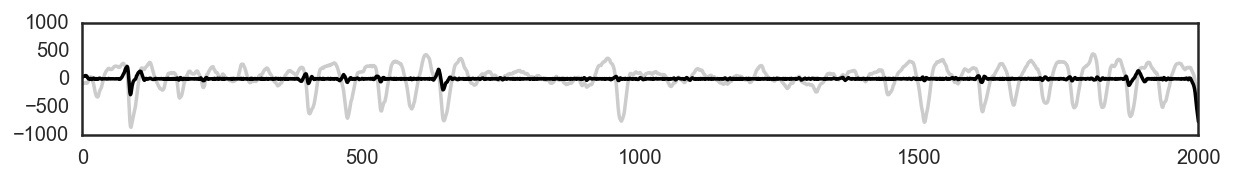

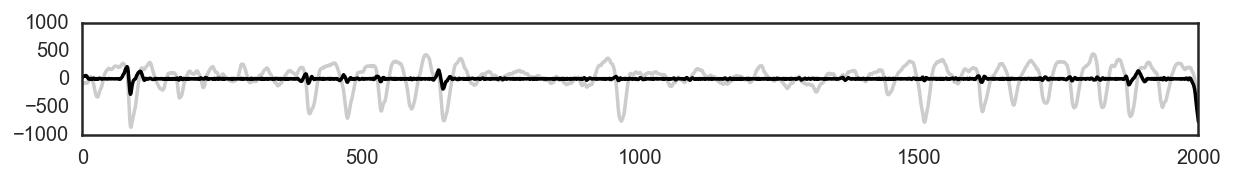

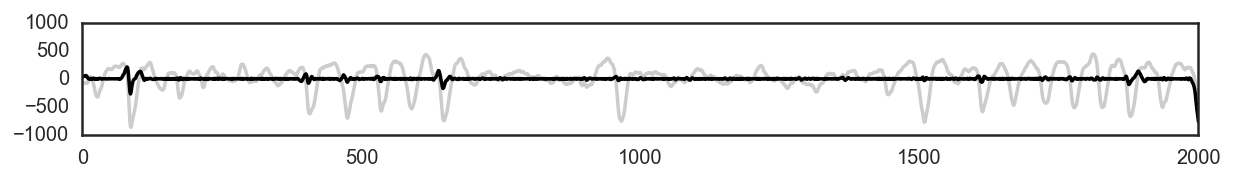

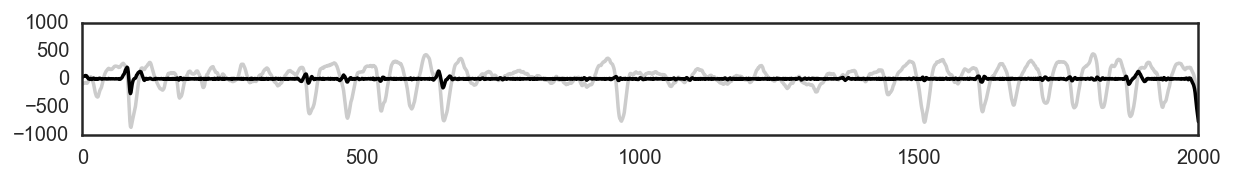

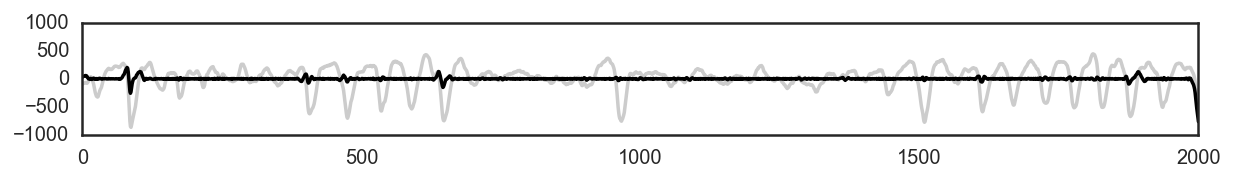

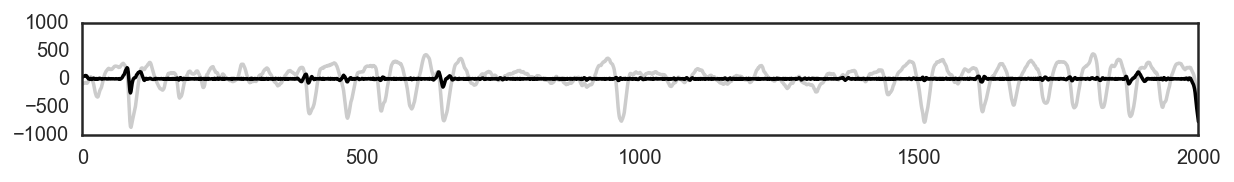

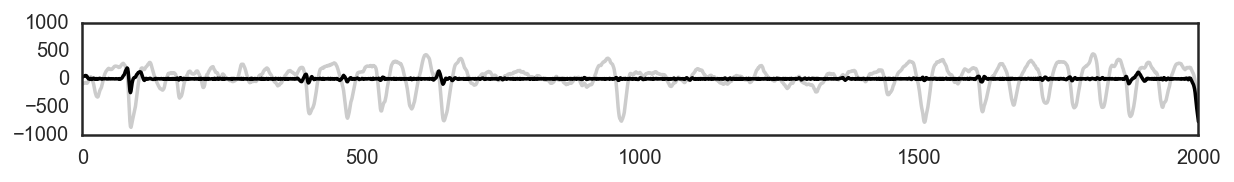

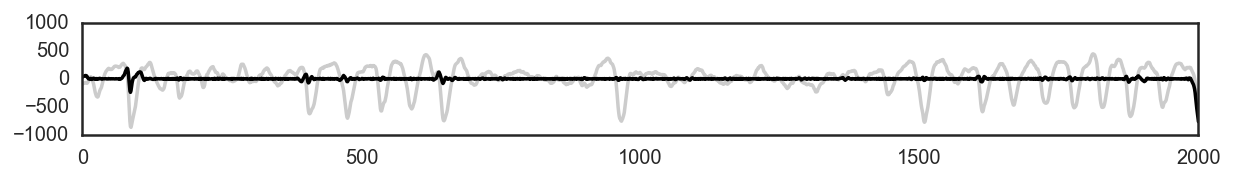

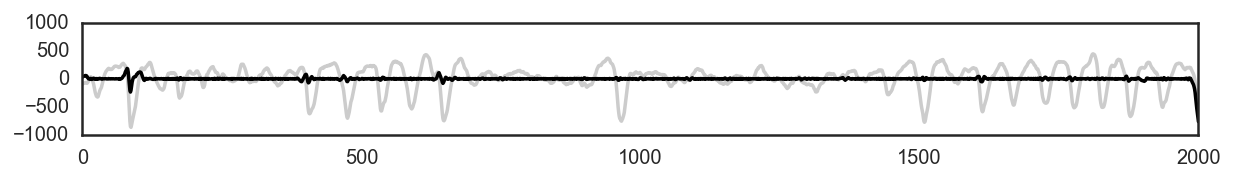

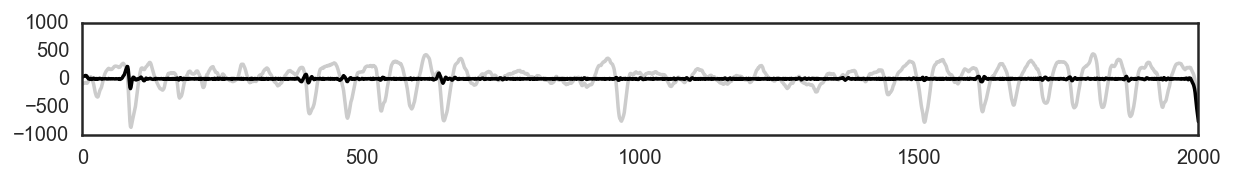

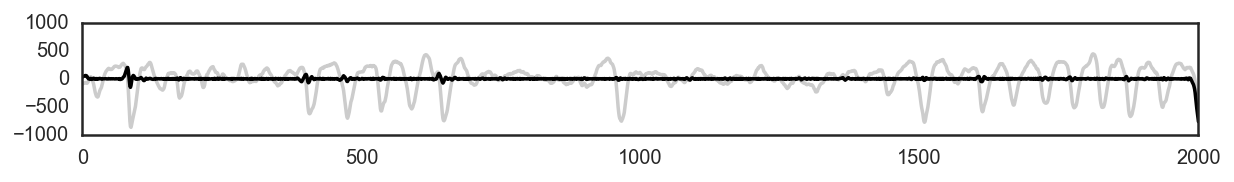

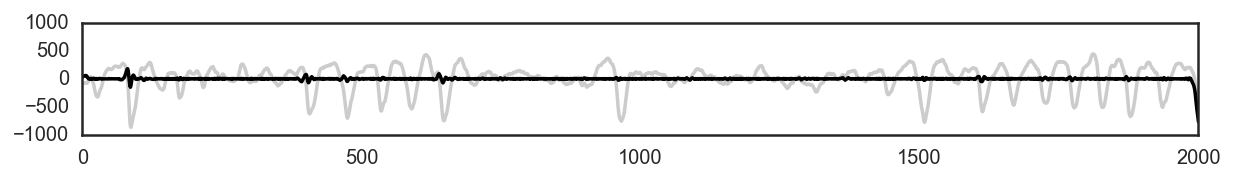

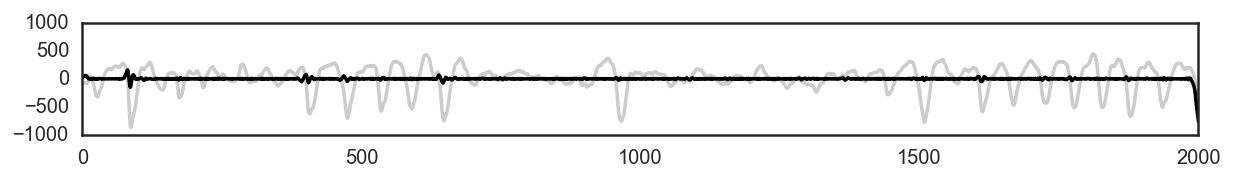

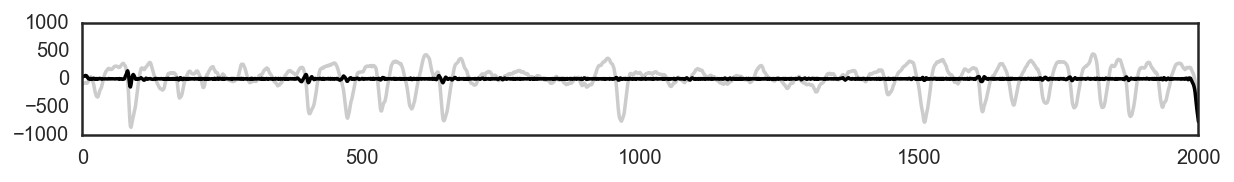

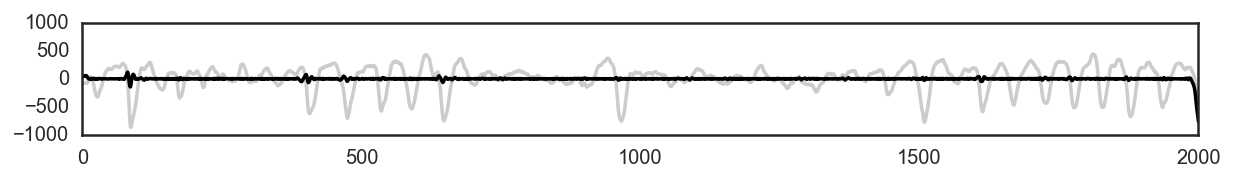

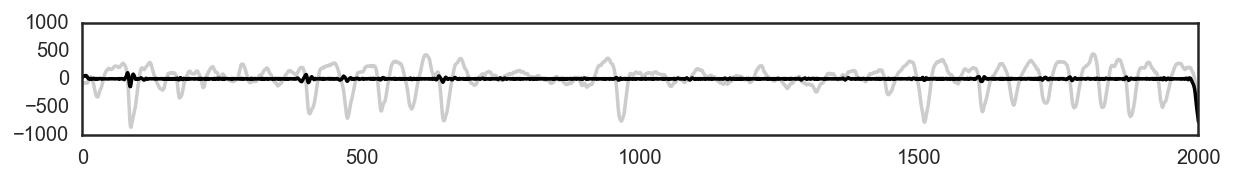

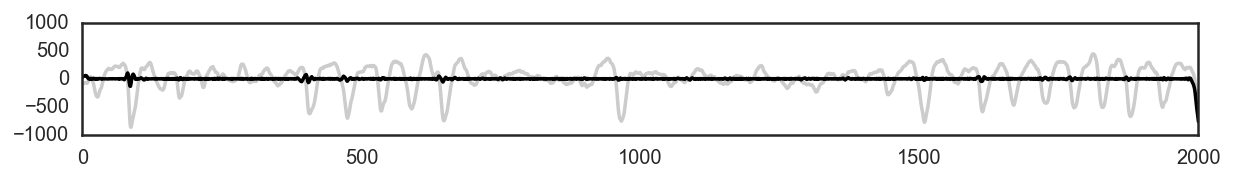

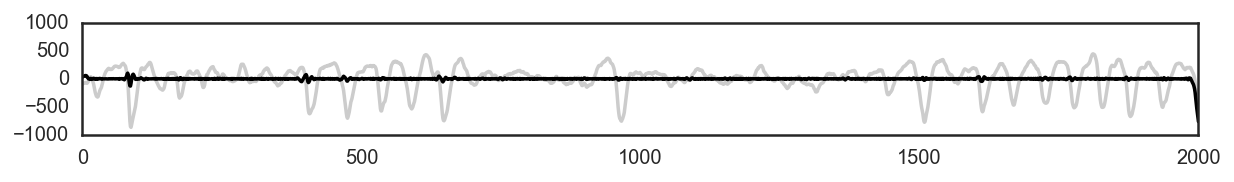

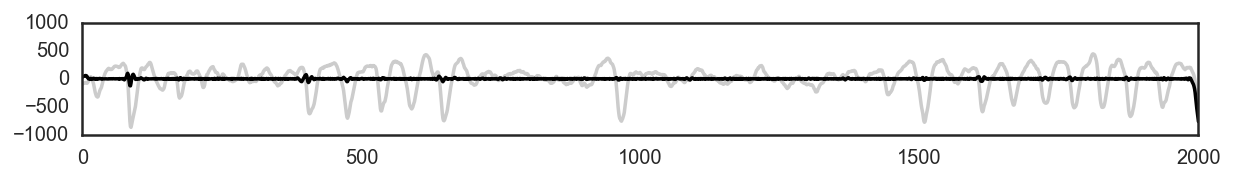

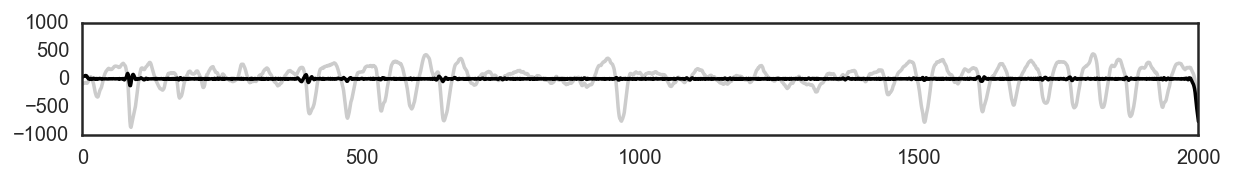

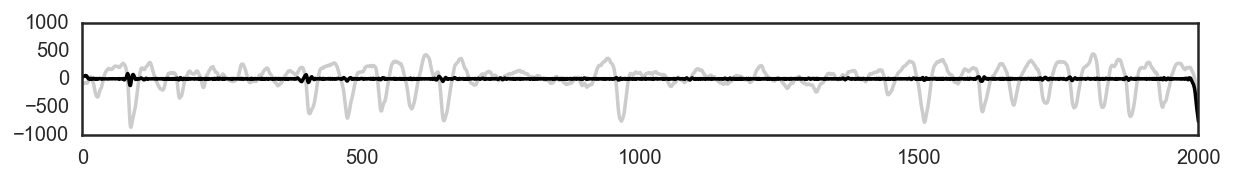

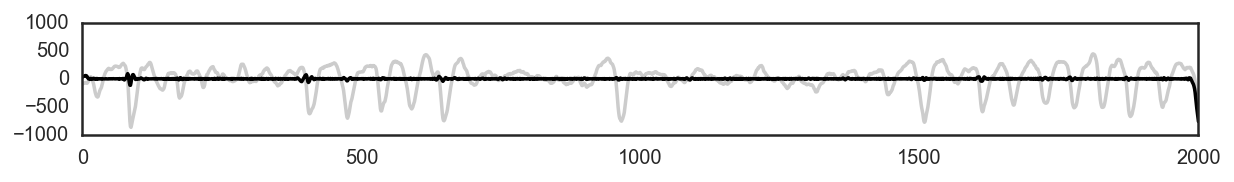

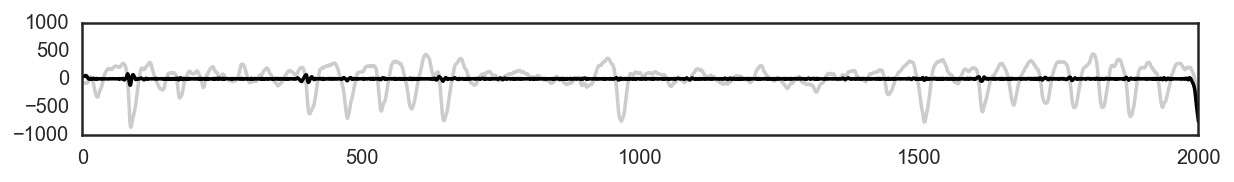

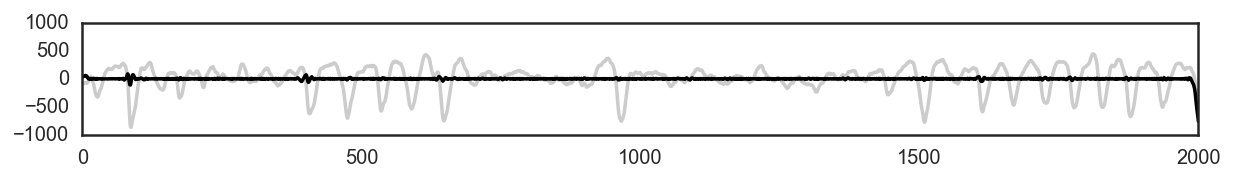

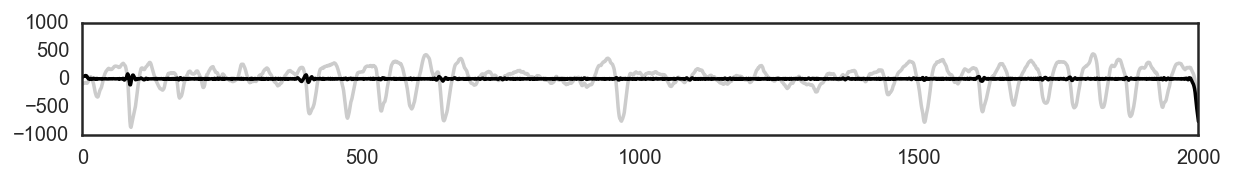

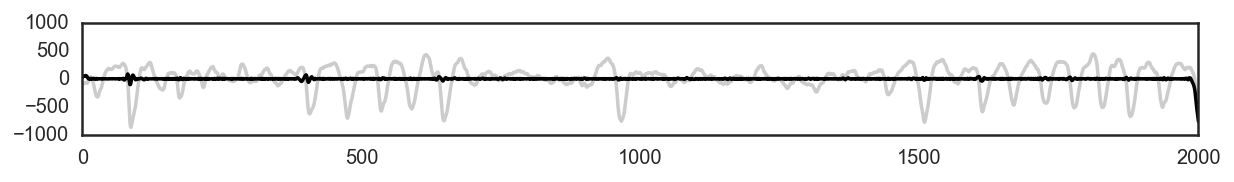

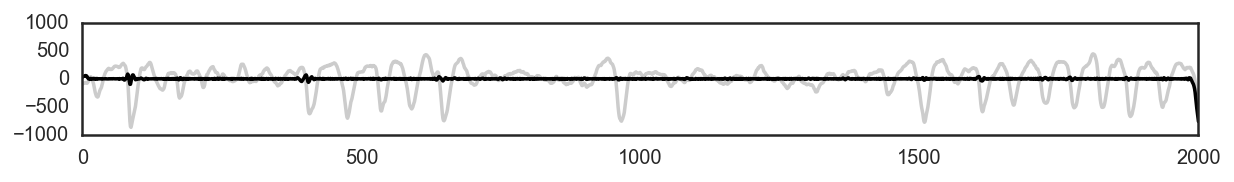

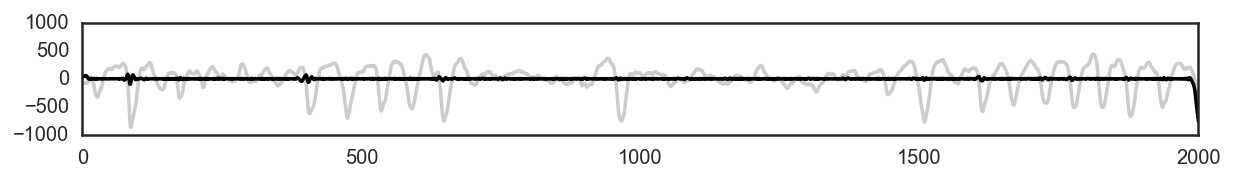

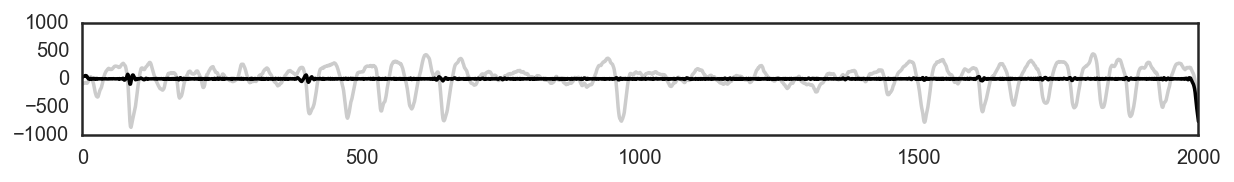

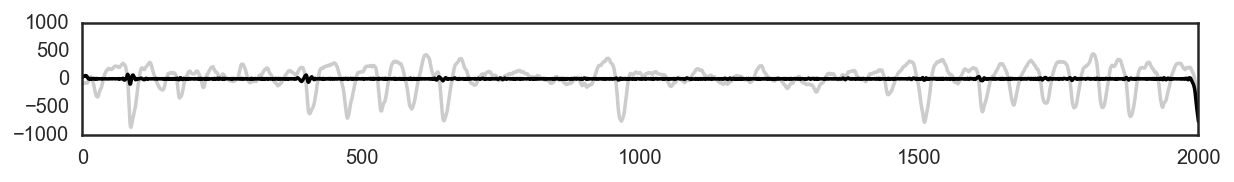

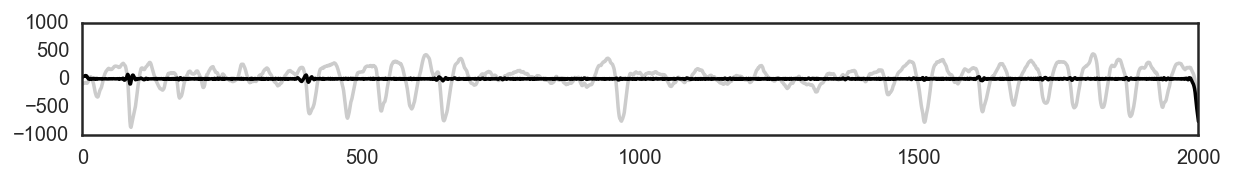

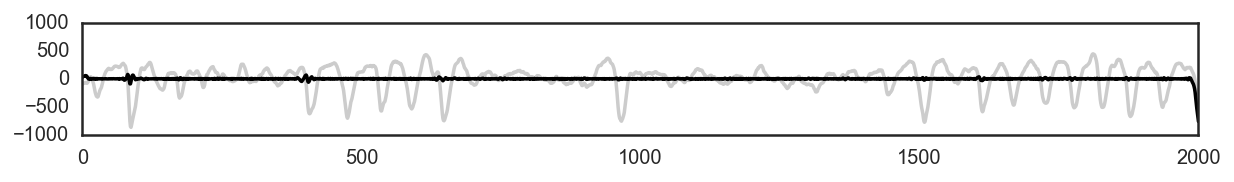

In [18]:
r = findnextcomponent(x,x,t)

**IMF 2**

IMF found!


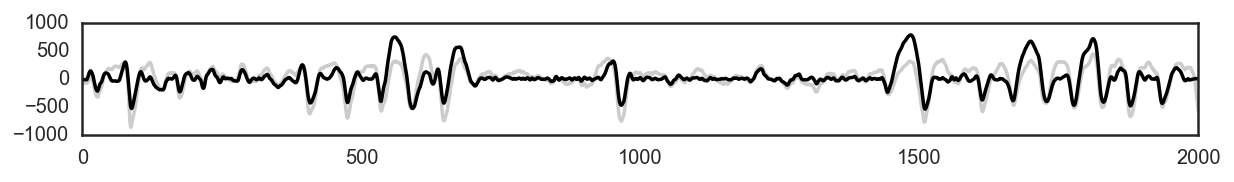

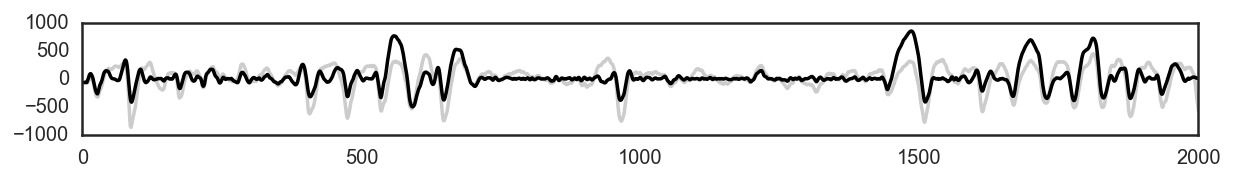

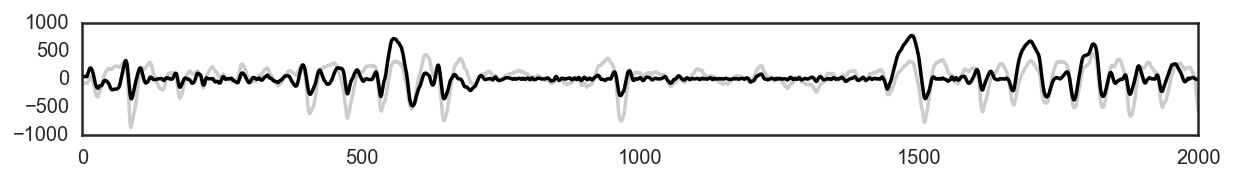

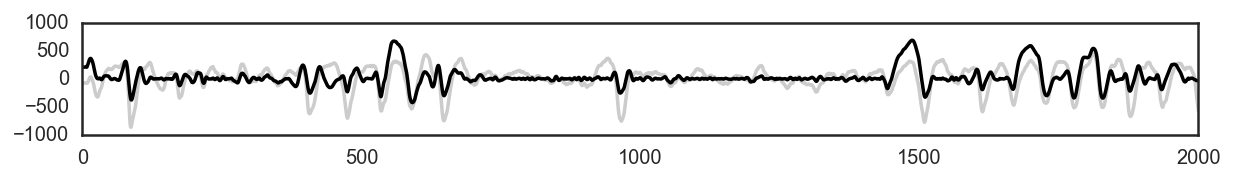

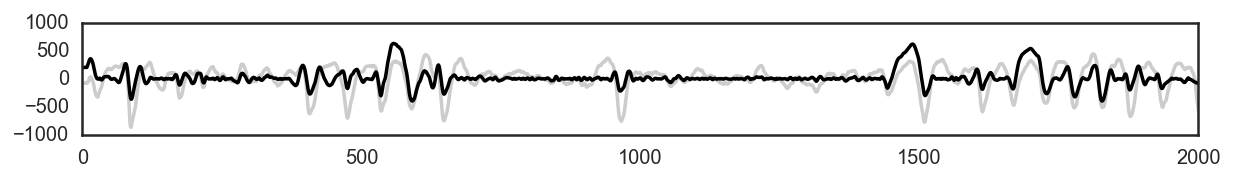

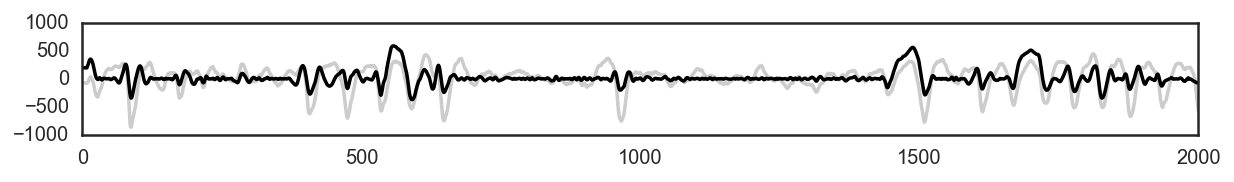

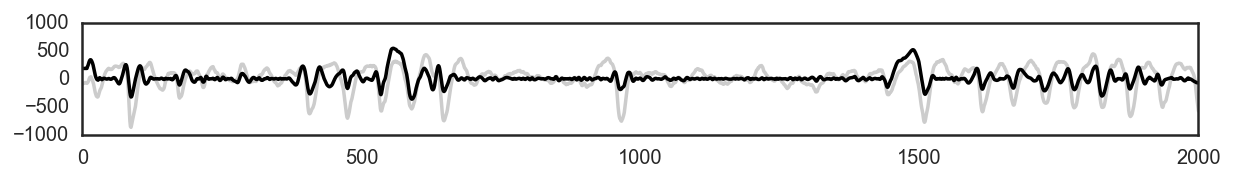

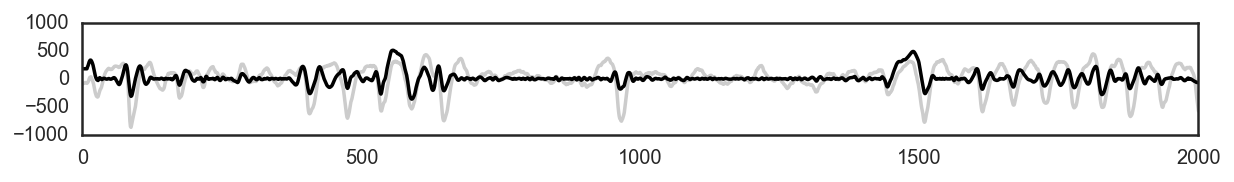

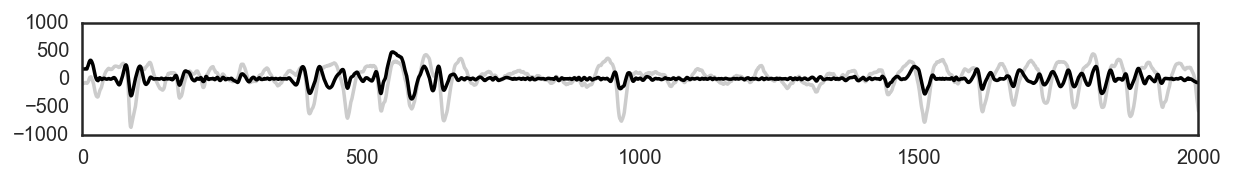

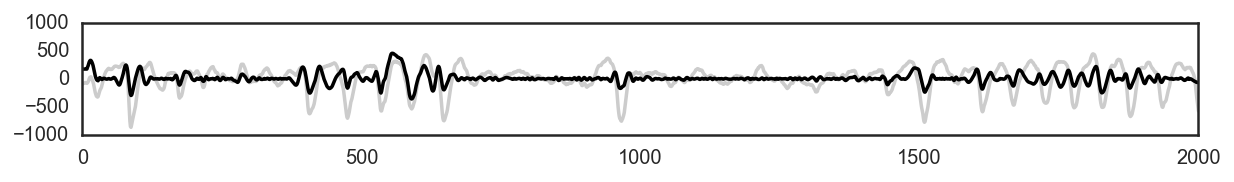

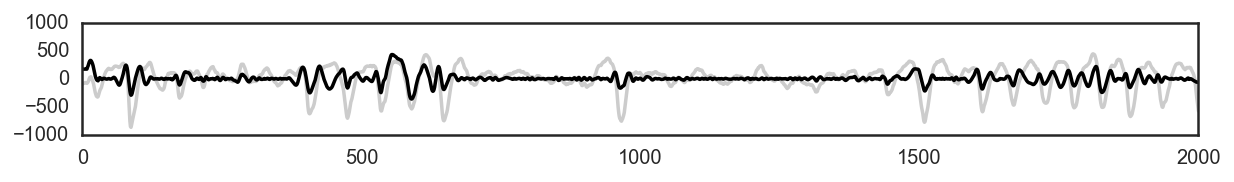

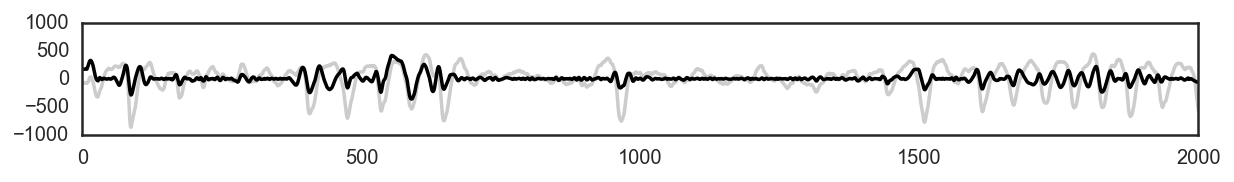

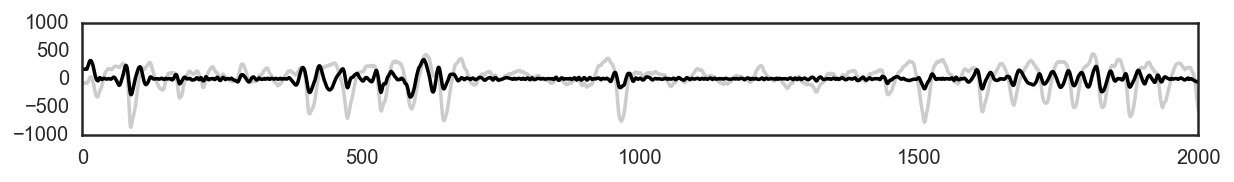

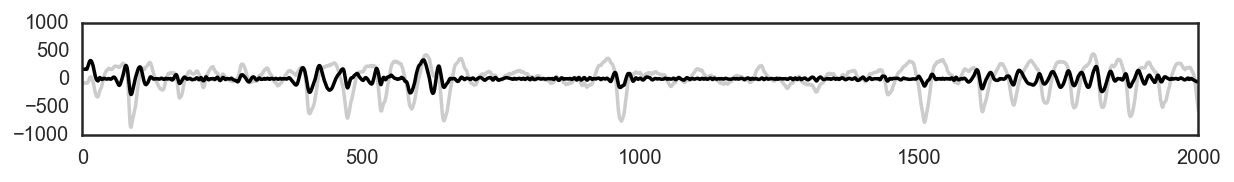

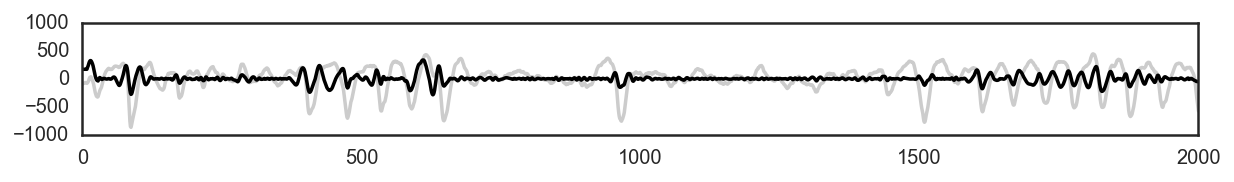

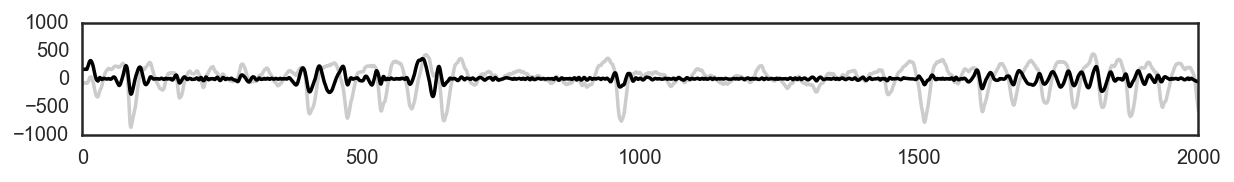

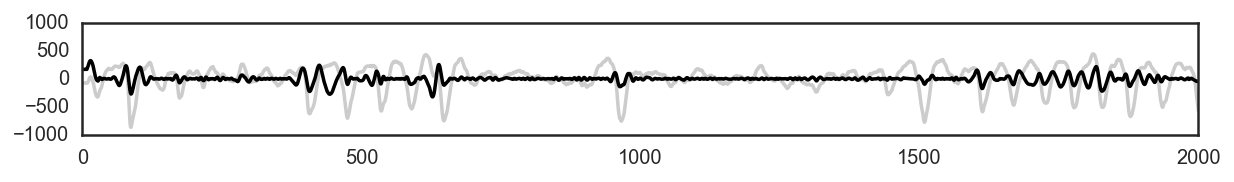

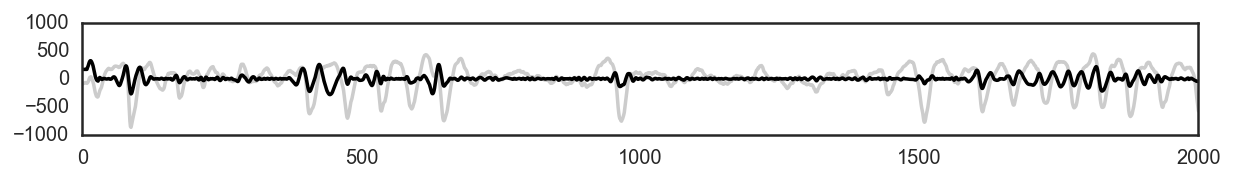

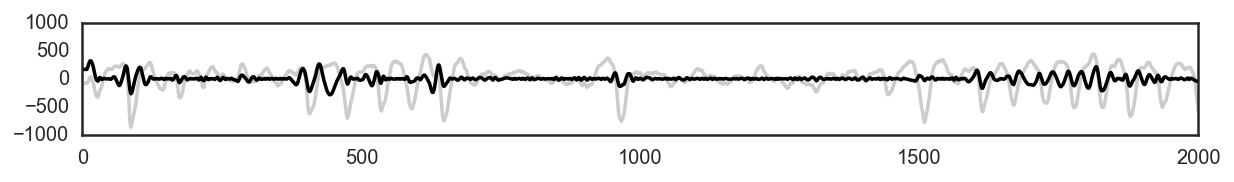

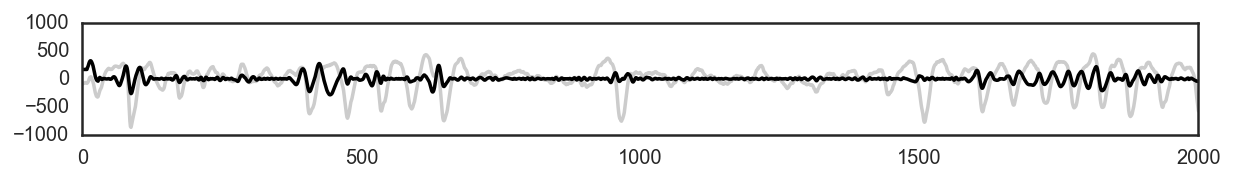

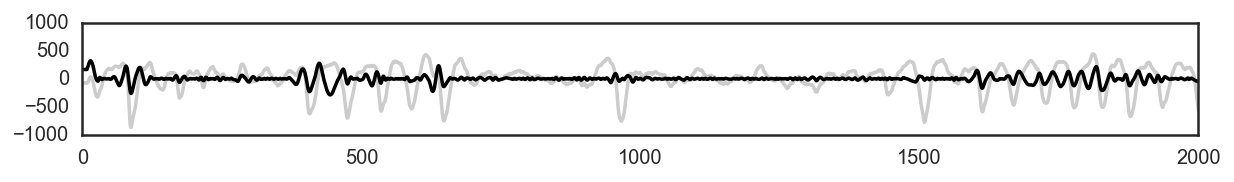

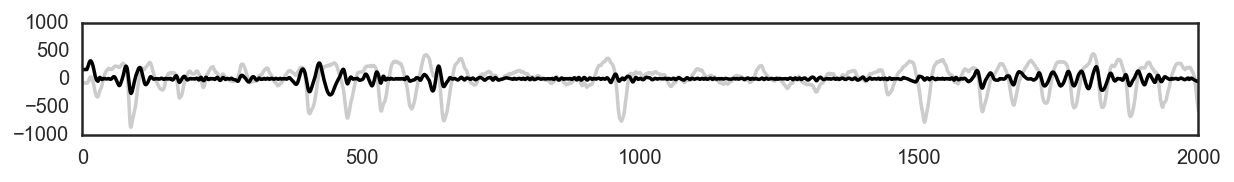

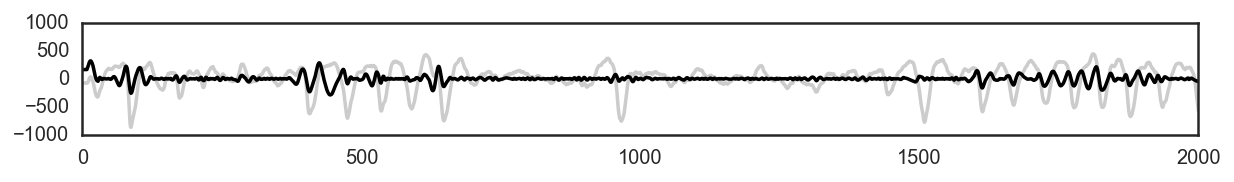

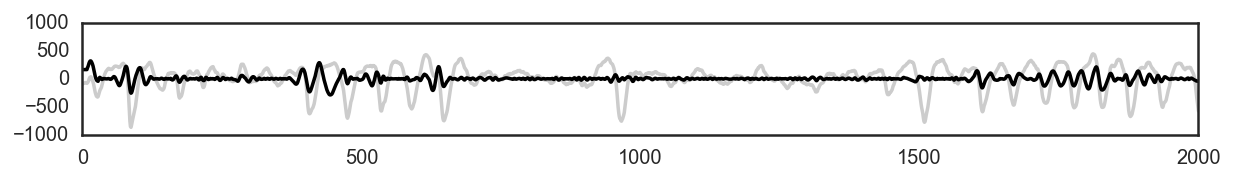

In [19]:
r = findnextcomponent(r,x,t)

**IMF 3**

IMF found!


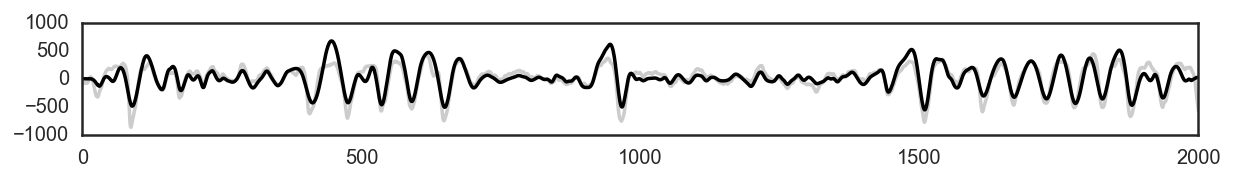

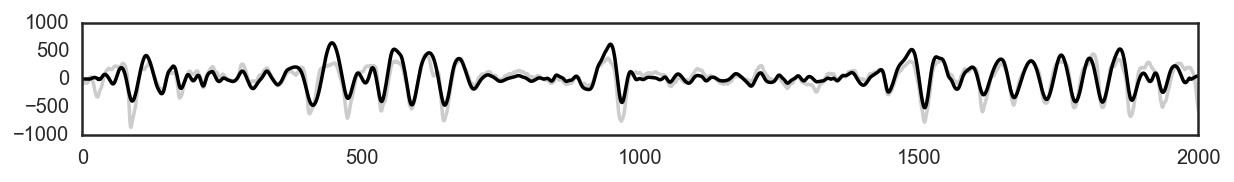

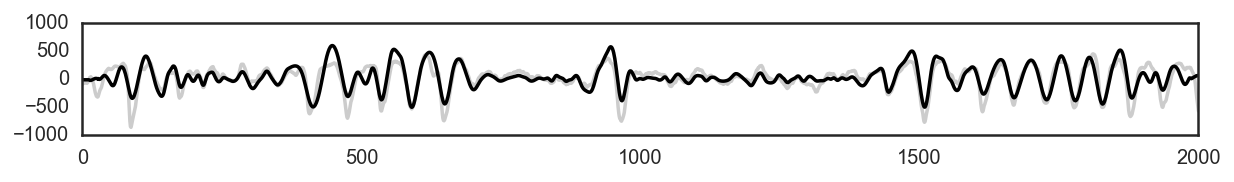

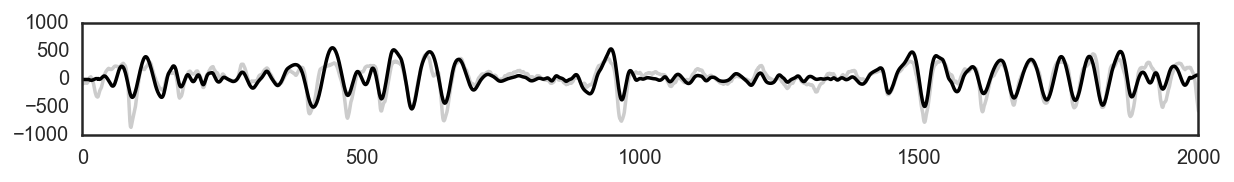

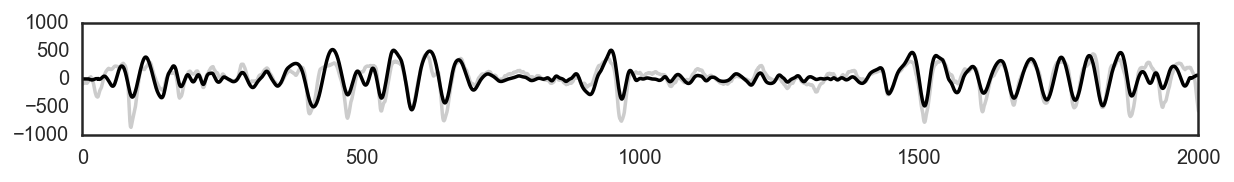

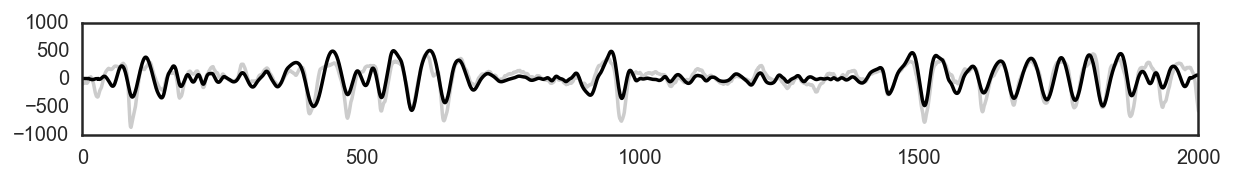

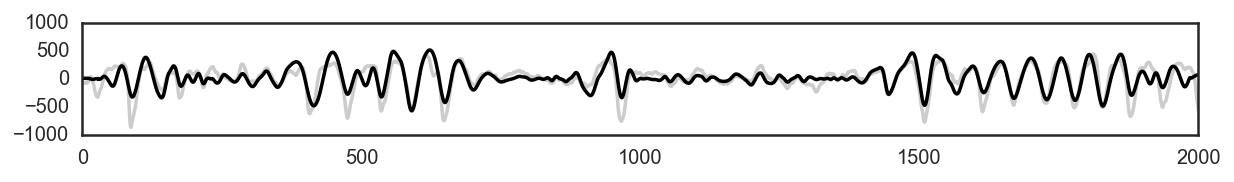

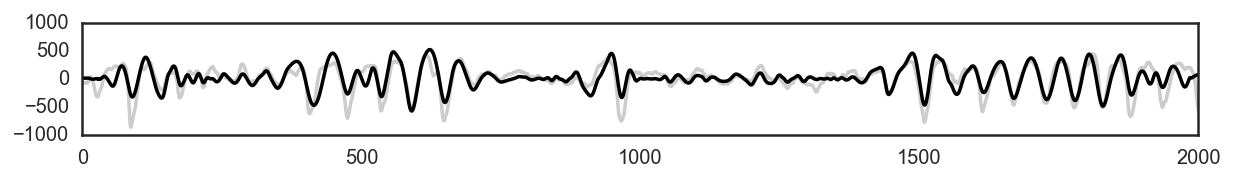

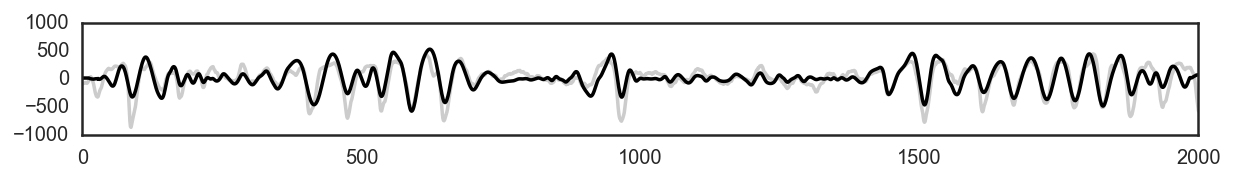

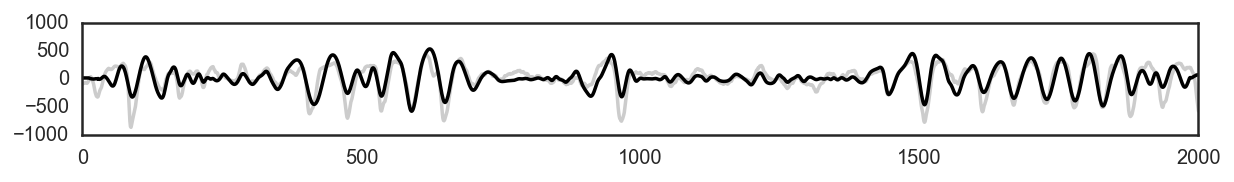

In [20]:
r = findnextcomponent(r,x,t)

# The end
I hope this helped give you an intuition behind EMD! Keep up to date with [my website](sxcole.com) for the next notebook about EMD application.